In [1]:
##because the memory of gpu is not enough, so sometimes the code cant run and show the result. Here is the example.
##we cant show the denoise of depth_bad_pixel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#for tensorboard adpation
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

#Additional Imports
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools as it
import datetime
import cv2 as cv
import os
import glob


#HPO
import optuna

#User defined we have set our own UNET, MultiInput_Unet,Unet_Dataset and MI_Dataset
from neural_networks import UNET, MultiInput_UNET
from data_set import UNET_Dataset, MI_Dataset

In [2]:
#Hier we test Unet_Model and MultipleUnet_Model and predicted images are saved for presentation


# to make the shape of image is 256*256,because the channel is 4 dimensions , for displaying the depth image the dimension needs to be 2 
def convert_to_image( y_pred, y_true, images, y_noisy = 0):
    
    rgb = []
    bad = []
    pred = []
    true = []
    i = 0
    for y in y_pred:
        pred.append(y.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256))
    for y in y_true:
        true.append(y.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256))
    if len(images[0][0,:,0,0]) == 3:
        #MultiInputNet
        for img in images:
            rgb.append(img.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256,3))
        for y in y_noisy:
            bad.append(y.cpu().detach().numpy().transpose((2,3,1,0)).reshape(128,128,3))
    else:
        #UNET
        for img in images:
            rgb.append(img.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256,4)[:,:,0:3])
            bad.append(img.cpu().detach().numpy().transpose((2,3,1,0)).reshape(256,256,4)[:,:,3])   
    return rgb, bad, pred, true

def save_trained_images(rgb, y_bad, y_pred, y_true, directory): #to save the images in a directory
    
    for idx in range(len(rgb)):
        plt.subplot(221), plt.imshow(rgb[idx])
        plt.subplot(222), plt.imshow(y_bad[idx],'gray')
        plt.subplot(223), plt.imshow(y_pred[idx],'gray')
        plt.subplot(224), plt.imshow(y_true[idx],'gray')
        plt.savefig(directory + 'img_{}'.format(idx) )


In [3]:
#HPO analyse

def get_best_trials(df, num_trials=1, by="value", ascending=True, split=False):
   
    sorted_trials = df.sort_values(by=by, ascending=ascending)
    
    if split:
        return sorted_trials[:num_trials], sorted_trials[num_trials:]
    return sorted_trials[:num_trials]

#Be sure to split your data into completed tasks and pruned tasks
def get_configs(df, param_start="params_", get_only_best=True):
   
    if get_only_best:
        df = get_best_trials(df, split=False)
        
    configs=[]
    
    #Get all config values
    params = [key for key in df.keys() if param_start in key]
    
    #Generate Dictionary with param values
    for idx, row in df.iterrows():
        config={param[len(param_start):] : row[param] for param in params}
        configs.append(config)
    
    return configs

In [4]:
#train function for unet model

def train_HPO_unet(model, dataloader, criterion, optimizer, device):
    
    epoch_loss = 0.0
    
    #Sets the Model on Training State
    model.train()
    
    #Start Trianing
    #for X, y_true in dataloader:
    for X, y_true in dataloader:
        model.zero_grad()

        X = torch.autograd.Variable(X.float())        
        y_true = torch.autograd.Variable(y_true)
        
        #Pack the Values onto the GPU or CPU
        X, y_true = X.to(device), y_true.to(device)

        #Predict Value
        y_pred = model(X.float())
        y_pred = y_pred.to(device)
        
        #Calculate loss
        batch_loss=criterion(y_pred.double(),y_true.double())
        epoch_loss += batch_loss.item() /len(dataloader)

        #Backpropagate and Optimize
        batch_loss.backward()
        optimizer.step()
        
        #Free gpu memory
        del X, y_true, y_pred
        torch.cuda.empty_cache()
    return epoch_loss


#Validation function for unet mode
def val_HPO_unet(model, dataloader, criterion, device):
   
    #VALIDATION
    model.eval()
    eval_loss = 0.0
    with torch.no_grad(): #In this Context -> No Adjustment of gradients
        #for X, y_true in dataloader:
        for X, y_true in dataloader:
            
            X = torch.autograd.Variable(X.float())
            y_true = torch.autograd.Variable(y_true)
            
            #Pack the Values onto the GPU or CPU
            X, y_true = X.to(device), y_true.to(device)
            
            #Predict Value
            y_pred = model(X.float())
            y_pred = y_pred.to(device)
            
            eval_loss += criterion(y_pred.double(), y_true.double()).item() / len(dataloader)
            
            #Free gpu memory
            del X, y_true, y_pred
            torch.cuda.empty_cache()
    return eval_loss

In [5]:
#train function for mi model
def train_HPO_mi(model, dataloader, criterion, optimizer, device):
    
    epoch_loss = 0.0
    
    #Sets the Model on Training State
    model.train()
    
    #Start Trianing
    #for X, y_true in dataloader:
    for X, y_bad, y_true in dataloader:
        model.zero_grad()

        X = torch.autograd.Variable(X.float())        
        y_true = torch.autograd.Variable(y_true)
        y_bad = torch.autograd.Variable(y_bad)
        
        #Pack the Values onto the GPU or CPU
        X, y_true, y_bad = X.to(device), y_true.to(device), y_bad.to(device)

        #Predict Value
        y_pred = model(X.float(), y_bad.float())
        y_pred = y_pred.to(device)
        
        #Calculate loss
        batch_loss=criterion(y_pred.double(),y_true.double())
        epoch_loss += batch_loss.item() /len(dataloader)

        #Backpropagate and Optimize
        batch_loss.backward()
        optimizer.step()
        
        #Free gpu memory
        del X, y_true, y_pred, y_bad
        torch.cuda.empty_cache()
    return epoch_loss

#val function for mi model
def val_HPO_mi(model, dataloader, criterion, device):
   
    #VALIDATION
    model.eval()
    eval_loss = 0.0
    with torch.no_grad(): #In this Context -> No Adjustment of gradients
        #for X, y_true in dataloader:
        for X, y_bad, y_true in dataloader:
            
            X = torch.autograd.Variable(X.float())
            y_true = torch.autograd.Variable(y_true)
            y_bad = torch.autograd.Variable(y_bad)
            
            #Pack the Values onto the GPU or CPU
            X, y_true, y_bad = X.to(device), y_true.to(device), y_bad.to(device)
            
            #Predict Value
            y_pred = model(X.float(), y_bad.float())
            y_pred = y_pred.to(device)
            
            eval_loss += criterion(y_pred.double(), y_true.double()).item() / len(dataloader)
            
            #Free gpu memory
            del X, y_true, y_pred, y_bad
            torch.cuda.empty_cache()
    return eval_loss

In [6]:
#test function for mi model
def test_mi(model, max_numb, device=torch.device("cpu")):
   
    
    test_loader = DataLoader(data_set_mi, batch_size = 1, sampler=test_sampler, drop_last=True)
    y_pred = []
    y_real = []
    img = []
    y_noisy = []
    test_loss = 0.0
    i = 0
    for image, y_bad, y_true in test_loader:
        image, y_bad, y_true = image.to(device), y_bad.to(device), y_true.to(device)
        model.to(device)
        y_pred.append(model(image.float(), y_bad.float()))
        y_real.append(y_true)
        test_loss += criterion(y_pred[-1].double(), y_true[-1].double()).item()/max_numb
        img.append(image)
        y_noisy.append(y_bad)
        i += 1
        if i == max_numb: # only predict max_numb test images
            break
    return img, y_noisy, y_pred, y_real

#test function for unet model
def test_unet(model, max_numb, device=torch.device("cpu")):
   
    test_loader = DataLoader(data_set_unet, batch_size = 1, sampler=test_sampler, drop_last=True)
    y_pred = []
    y_real = []
    y_noisy = []
    img = []
    test_loss = 0.0
    i = 0
    for image,  y_true in test_loader:
        image,  y_true = image.to(device), y_true.to(device)
        model.to(device)
        y_pred.append(model(image.float()))
        y_real.append(y_true)
        test_loss += criterion(y_pred[-1].double(), y_true[-1].double()).item()/max_numb
        img.append(image)
        i += 1
        if i == max_numb: # only predict 10 test images
            break
    return img, y_pred, y_real

In [7]:
analyse = {
    "unet": {
    "model" : UNET,
    "study_name" : "unet_study",
    "storage" : "sqlite:///HPO/optuna_db/unet_hpo.db",
    },
    "mi":{
    "model" : MultiInput_UNET,
    "study_name" : "mi_study",
    "storage" : "sqlite:///HPO/optuna_db/mi_hpo.db"
    }
}

unet_configs = []
mi_configs = []

for hpo_config in analyse.values():
    study = optuna.create_study(
        study_name=hpo_config["study_name"],
        storage=hpo_config["storage"],
        load_if_exists=True)
    
    df_c = study.trials_dataframe().loc[study.trials_dataframe()["state"]=="COMPLETE"]
    config = get_configs(df_c)
    
    if hpo_config["model"] is UNET:
        unet_configs.extend(config)
    elif hpo_config["model"] is MultiInput_UNET:
        mi_configs.extend(config)
    else:
        raise ValueError ("Model {} is not included.".format(hpo_config["model"]))

print("Best Configs:")
print("UNET: ", unet_configs)
print("MultiInput: ",mi_configs)

[I 2022-07-17 02:36:45,752] Using an existing study with name 'unet_study' instead of creating a new one.
[I 2022-07-17 02:36:46,125] Using an existing study with name 'mi_study' instead of creating a new one.


Best Configs:
UNET:  [{'activation': 'relu', 'batch_size': 4, 'dropout_rate': 0.010090208163236069, 'kernel': 3, 'learning_rate': 0.0005408663438029292}]
MultiInput:  [{'activation': 'relu', 'batch_size': 4, 'dropout_rate': 0.000865546206435655, 'kernel': 3, 'learning_rate': 0.00038404385470179044}]


In [8]:
#Preprocess Configrations by HPO

#Round Values of the Unet-Config
##to store key value pairs or some configurable information
for config in unet_configs:
    #Unet-Config of HPO
    config["dropout_rate"] = round(config["dropout_rate"], 3)
    config["learning_rate"] = round(config["learning_rate"], 5)

#Unet-Config of Self
unet_config_self= unet_configs[0].copy()
unet_config_self["batch_size"]=8
unet_config_self["dropout_rate"]=0.2
unet_config_self["learning_rate"] = 0.001
unet_configs.append(unet_config_self)

##here below can be removed, because its for mi
#Round Values of the MI-Config
for config in mi_configs:
    config["dropout_rate"] = round(config["dropout_rate"], 5)
    config["learning_rate"] = round(config["learning_rate"], 5)

#Mulitinput Config of self
mi_config_self= mi_configs[0].copy()
mi_config_self["dropout_rate"] = 0.2
mi_config_self["learning_rate"] = 0.001
mi_config_self["batch_size"] = 8
mi_configs.append(mi_config_self)

print("[Best Configs rounded, self initialized]:")
print("UNET: ", unet_configs)
print("MultiInput: ",mi_configs)

[Best Configs rounded, self initialized]:
UNET:  [{'activation': 'relu', 'batch_size': 4, 'dropout_rate': 0.01, 'kernel': 3, 'learning_rate': 0.00054}, {'activation': 'relu', 'batch_size': 8, 'dropout_rate': 0.2, 'kernel': 3, 'learning_rate': 0.001}]
MultiInput:  [{'activation': 'relu', 'batch_size': 4, 'dropout_rate': 0.00087, 'kernel': 3, 'learning_rate': 0.00038}, {'activation': 'relu', 'batch_size': 8, 'dropout_rate': 0.2, 'kernel': 3, 'learning_rate': 0.001}]


In [11]:
# Train two UNET , one with best parameters and one with self choosen parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root = r"C:/Users/49162/Desktop/python/images/"
camera_dir = r"camera/"
sensor_dir = r"gaussian_noise_depth_sigma10/"
masks_dir = r"depth_real/"

train_size = 0.8
test_size = 0.1
val_size = 0.1

data_set_unet = UNET_Dataset(root, camera_dir, sensor_dir, masks_dir)

#shuffle indexes
sample_idx = [i for i in range(len(data_set_unet))]
np.random.shuffle(sample_idx)
len_train = int(len(data_set_unet) * train_size)
len_val = int(len(data_set_unet) * val_size)
train_idx = sample_idx[:len_train]
val_idx = sample_idx[len_train:len_train+len_val]
test_idx = sample_idx [len_train+len_val:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)
    

unet_models = []

for config in unet_configs: 
    train_loader = DataLoader(data_set_unet, batch_size = config['batch_size'], sampler=train_sampler, drop_last=True)
    val_loader = DataLoader(data_set_unet, batch_size = config['batch_size'], sampler=val_sampler, drop_last=True)
    
    #Model
    model = UNET(in_features  = 4, 
                    out_features = 1, 
                    batch_size   = config['batch_size'],
                    kernel       = config['kernel'],
                    activation   = getattr(torch, config['activation']),
                    dropout_rate = config['dropout_rate'])
    
    #Optimizer and Criterions
    optimizer = optim.Adam(model.parameters(), lr= config['learning_rate'])
    criterion = torch.nn.MSELoss()
    
    #Set to GPU
    model = model.to(device)
    criterion = criterion.to(device)
    
    #Start Evaluating
    val_loss = 0.0
    ret_val = 0.0
    epochs = 20 # can adjust the epochs to get the better result
    
    min_val_loss = 20.0
    epoch_losses = []
    val_losses = []
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        print("Starting Epoch [{}/{}]".format(epoch+1, epochs))
        
        #Train
        epoch_loss = train_HPO_unet(model, train_loader, criterion, optimizer, device)
        epoch_losses.append(epoch_loss)
        
        #Val
        val_loss = val_HPO_unet(model, val_loader, criterion, device)
        val_losses.append(val_loss)
           
        #early_stopping
        if val_loss < min_val_loss: 
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
        #print("after: ", min_val_loss, eval_loss, epochs_no_improve)
        if epochs_no_improve > 5:
            print("Early stopping")
            early_stop = True
            break
            
        print("Validation loss: {}".format(round(val_loss,6)))
    
    #save model
    unet_models.append(model)
    torch.save({'model':model,
                'model_state_dict':model.state_dict(),
                'epoch_losses':epoch_losses,
                'val_losses':val_losses
               }, r'C:/Users/49162/Desktop/python/trained_NNs/UNET_bs{}_dr{:{width1}.{prec1}f}_lr{:{width2}.{prec2}f}.pt'.format(config['batch_size'],config['dropout_rate'],config['learning_rate'] ,width1 = 4, prec1 = 2, width2=7, prec2=5))
    
    
        

Starting Epoch [1/20]
Validation loss: 0.000992
Starting Epoch [2/20]
Validation loss: 0.000597
Starting Epoch [3/20]
Validation loss: 0.000382
Starting Epoch [4/20]
Validation loss: 0.000344
Starting Epoch [5/20]
Validation loss: 0.000261
Starting Epoch [6/20]
Validation loss: 0.00024
Starting Epoch [7/20]
Validation loss: 0.000245
Starting Epoch [8/20]
Validation loss: 0.000239
Starting Epoch [9/20]
Validation loss: 0.000227
Starting Epoch [10/20]
Validation loss: 0.00021
Starting Epoch [11/20]
Validation loss: 0.000236
Starting Epoch [12/20]
Validation loss: 0.000196
Starting Epoch [13/20]
Validation loss: 0.000285
Starting Epoch [14/20]
Validation loss: 0.000184
Starting Epoch [15/20]
Validation loss: 0.000159
Starting Epoch [16/20]
Validation loss: 0.00016
Starting Epoch [17/20]
Validation loss: 0.000145
Starting Epoch [18/20]
Validation loss: 0.00021
Starting Epoch [19/20]
Validation loss: 0.000147
Starting Epoch [20/20]
Validation loss: 0.00015
Starting Epoch [1/20]
Validation l

C:\Users\49162\anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


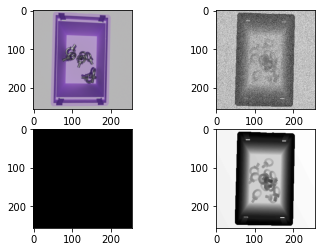

In [12]:
#Test model and save predicted images
cwd = os.getcwd()

for file_name in glob.glob(r"C:/Users/49162/Desktop/python/trained_NNs/U*"):
    model = torch.load(file_name)['model']
    img,  y_pred, y_true = test_unet(model, 20, device=torch.device("cpu"))
    rgb, bad, pred, true = convert_to_image(y_pred, y_true, img)
    directory = os.path.join(cwd,'C:/Users/49162/Desktop/python/trained_NNs/Predicted_Images_unet_{}'.format(file_name[-23:-3]))
    if not os.path.exists(directory):
        os.mkdir(directory)
    save_trained_images(rgb, bad, pred, true, directory+"/")
    ##because I set the learning rate is 0.001 and dropout rate is 0.2, they are so big, so the final effect is not good.

In [17]:
#plot epoch loss, val loss and save figures
import matplotlib.patches as mpatches

cwd = os.getcwd()
i=1
for file_name in glob.glob(r"C:/Users/49162/Desktop/python/trained_NNs/U*"):
    val_loss = torch.load(file_name)['val_losses']
    epoch_loss = torch.load(file_name)['epoch_losses']
    numb_epochs = len(val_loss)
    
    plt.plot(np.arange(numb_epochs),val_loss, label='validation loss')
    plt.plot(np.arange(numb_epochs),epoch_loss, label='epoch loss')
    plt.ylim(top=0.002)
    plt.ylim(bottom=0.00)
    #red_patch = mpatches.Patch(color='red', label='val_loss')
    #blue_patch = mpatches.Patch(color='blue', label='epoch_loss')
       
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)

    plt.savefig(cwd+'/trained_NNs/Losses/Losses_unet_{}.png'.format(i))
    i+=1
    plt.clf()

<Figure size 432x288 with 0 Axes>